In [295]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

file = '/Users/leeyu/Documents/GitHub/MLGame/games/arkanoid/log/ml_NORMAL_3_2020-07-20_23-03-47.pickle'
with open(file, 'rb') as f:
    data = pickle.load(f)

print(data.keys())
print(len(data['scene_info']), len(data['command']))

dict_keys(['scene_info', 'command'])
1898 1898


In [296]:
data['scene_info'][0]

{'frame': 0,
 'status': 'GAME_ALIVE',
 'ball': (93, 395),
 'platform': (75, 400),
 'bricks': [(50, 60),
  (75, 60),
  (100, 60),
  (125, 60),
  (60, 70),
  (85, 70),
  (110, 70),
  (50, 80),
  (75, 80),
  (100, 80),
  (125, 80)],
 'hard_bricks': [(35, 50),
  (60, 50),
  (85, 50),
  (110, 50),
  (135, 50),
  (25, 60),
  (150, 60),
  (35, 70),
  (135, 70),
  (25, 80),
  (150, 80),
  (35, 90),
  (60, 90),
  (85, 90),
  (110, 90),
  (135, 90)]}

In [297]:
data['command'][0]

'SERVE_TO_RIGHT'

In [298]:
# 讓資料變大 7774208
# for i in range(12):
#     data['scene_info'] += data['scene_info']
#     data['command'] += data['command']

In [299]:
print(len(data['scene_info']), len(data['command']))

1898 1898


In [300]:
# 提取特徵
# 計算一般迴圈及list方法所需時間
from time import time
s = time()

Ball_x = []
Ball_y = []
Ball_speed_x = []
Ball_speed_y = []
Direction = []
Platform = []
Command = []

for i, sceneInfo in enumerate(data["scene_info"][1:-2]):
    Ball_x.append(sceneInfo['ball'][0])
    Ball_y.append(sceneInfo['ball'][1])
    Platform.append(sceneInfo['platform'][0])
    Ball_speed_x.append(data['scene_info'][i+2]["ball"][0]-data['scene_info'][i+1]["ball"][0])
    Ball_speed_y.append(data['scene_info'][i+2]["ball"][1]-data['scene_info'][i+1]["ball"][1])
    if Ball_speed_x[-1] > 0:
        if Ball_speed_y[-1] > 0:
            Direction.append(0)
        else:
            Direction.append(1)
    else:
        if Ball_speed_y[-1] > 0:
            Direction.append(2)
        else:
            Direction.append(3)
for command in data["command"][1:-2]:
    if command == "NONE":
        Command.append(0)
    elif command == "MOVE_LEFT":
        Command.append(-1)
    elif command == "MOVE_RIGHT":
        Command.append(1)

e = time()
print(e - s)

0.006170034408569336


In [301]:
# 提取特徵
# 計算使用numpy方法所需時間
s = time()

k = range(1, len(data['scene_info'])-1)

ball_x = np.array([data['scene_info'][i]['ball'][0] for i in k])
ball_y = np.array([data['scene_info'][i]['ball'][1] for i in k])
ball_speed_x = np.array([data['scene_info'][i+1]['ball'][0] - data['scene_info'][i]['ball'][0] for i in k])
ball_speed_y = np.array([data['scene_info'][i+1]['ball'][1] - data['scene_info'][i]['ball'][1] for i in k])
direction = np.where(np.vstack((ball_speed_x, ball_speed_y)) > 0, [[1],[0]], [[2],[3]]).sum(axis=0)  # x y: ++1, +-4, -+2, --3
platform = np.array([data['scene_info'][i]['platform'][0] for i in k])
target = np.where(np.array(data['command']) == 'NONE', 0,
                  np.where(np.array(data['command']) == 'MOVE_LEFT', -1, 1))[1:-1]  # [0] SERVE_TO_RIGHT, [1897] None

e = time()
print(e - s)

0.006159067153930664


(array([937.,   0.,   2.,   3.,   2.,   2.,   2.,   3.,   0., 945.]),
 array([-7. , -5.6, -4.2, -2.8, -1.4,  0. ,  1.4,  2.8,  4.2,  5.6,  7. ]),
 <a list of 10 Patch objects>)

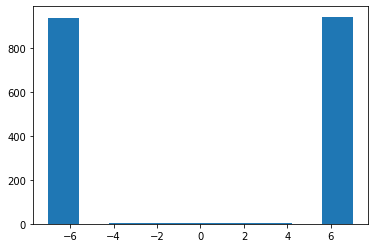

In [302]:
# 統計速度方向的數量
from collections import defaultdict
dd = defaultdict(int)
for i in ball_speed_x:
    dd[i] += 1
plt.hist(ball_speed_x)

In [303]:
list(dd.items()).sort()
print(sorted(list(dd.items())))

[(-7, 908), (-6, 29), (-4, 1), (-3, 1), (-2, 3), (-1, 2), (1, 2), (2, 2), (3, 1), (4, 2), (6, 30), (7, 915)]


In [304]:
# 計算變數大小
import sys
a = [Ball_x, Ball_y, Ball_speed_x, Ball_speed_y, Direction, Platform, Command]
b = [ball_x, ball_y, ball_speed_x, ball_speed_y, direction, platform, target]

for i in range(len(a)):
    print(sys.getsizeof(a[i]) / 1024, 'k', sys.getsizeof(b[i]) / 1024, 'k')

16.1796875 k 14.90625 k
16.1796875 k 14.90625 k
16.1796875 k 14.90625 k
16.1796875 k 14.90625 k
16.1796875 k 14.90625 k
16.1796875 k 14.90625 k
16.1796875 k 0.09375 k


In [305]:
# 比較資料一致性
for i in range(len(a)):
    for i1, i2 in zip(a[i], b[i]):
        if i != 4:
            if i1 != i2:
                print(i)
                print(i1, i2)
        else:
            if i1 == 0 and i2 != 1:
                print(i1, i2)
            if i1 == 1 and i2 != 4:
                print(i1, i2)
            if i1 == 2 and i2 != 2:
                print(i1, i2)
            if i1 == 3 and i2 != 5:
                print(i1, i2)

In [306]:
#train data
X = np.hstack((ball_x.reshape(-1, 1),
               ball_y.reshape(-1, 1),
               ball_speed_x.reshape(-1, 1),
               ball_speed_y.reshape(-1, 1),
               direction.reshape(-1, 1),
               platform.reshape(-1, 1)))
y = target

In [307]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=3)
print(model.fit(X, y))
print(model.score(X, y))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')
0.979957805907173


In [308]:
with open('my_model.pickle', 'wb') as f:
    pickle.dump(model, f)